# Pointing group generation and visualization

## Description:
This notebook generates, loads, and displays the Pointing Groups for the Lori Allen Data Processing. The file "pointing_groups.dat" is the current frozen version of the pointings and can be loaded in the second cell.



In [1]:
import pointings

%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from astropy import time
import numpy as np

In [2]:
# Load in the pointings, or regenerate the pointing groups from the raw VOT table metadata

# Run this to load in from a pickled file
pg = pointings.PointingGroups.load('pointing_groups.dat')

# Run this to regenerate the pointing groups from the raw VOT table metadata
# Note, you must first extract "VOTMetadata.tar.bz2"

"""
MetaTable = pointings.read_pointings(filePath="VOTMetadata/")
pg = pointings.PointingGroups(table=MetaTable,raTol=1e-2,deTol=2e-2)
pg.groups = sorted(pg.groups, key=len, reverse=True)
pg.write('pointing_groups.dat')
"""


'\nMetaTable = pointings.read_pointings(filePath="VOTMetadata/")\npg = pointings.PointingGroups(table=MetaTable,raTol=1e-2,deTol=2e-2)\npg.groups = sorted(pg.groups, key=len, reverse=True)\npg.write(\'pointing_groups.dat\')\n'

In [3]:
def plot_pointings(visit_id, ra, dec):
    arcsec2degree = 0.000277778
    pixscale = 0.2637 #arcsec/px
    
    height   = 2048 * pixscale * arcsec2degree
    width    = 4096 * pixscale * arcsec2degree
    angle    = [0]*len(ra)

    fig, ax = plt.subplots(figsize=(10, 7))

    rect_patches = []
    for i, r, d, a in zip(visit_id, ra, dec, angle):
        # this will likely kill the notebook
        #annot = ax.text(r-0.001, d-0.001, i, fontsize=12)
        #                 lower left corner        height  width  angle
        rect = Rectangle((r-height/2., d-width/2.), height, width, a)
        rect_patches.append(rect)
    rect_patches_collection = PatchCollection(rect_patches, alpha=0.1)
    ax.add_collection(rect_patches_collection)

    ax.scatter(ra, dec, color="red")

<IPython.core.display.Javascript object>


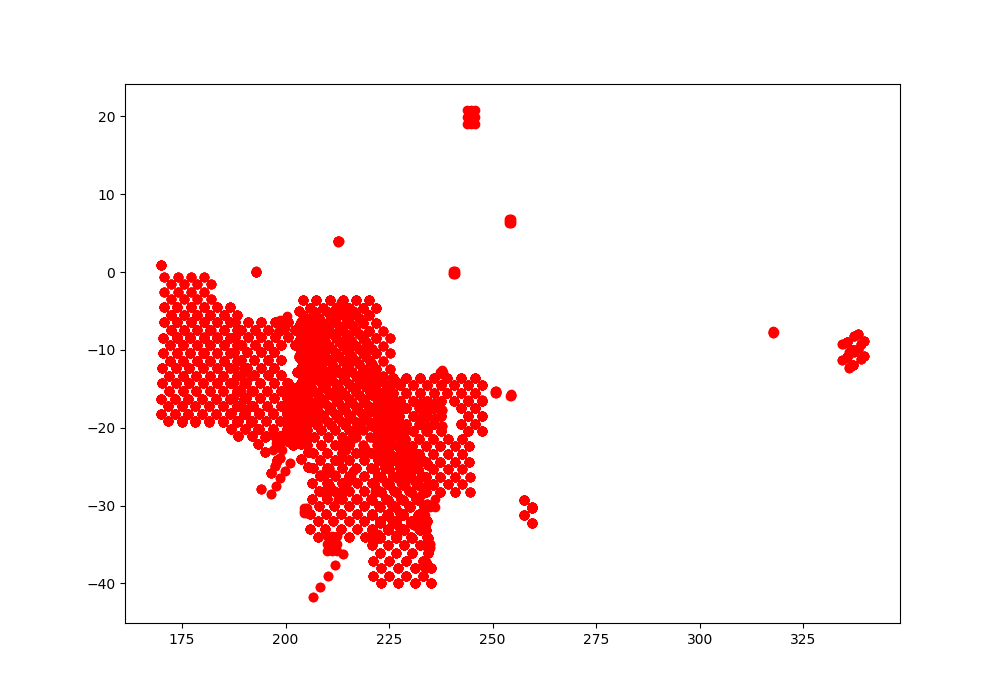

In [4]:
# make a plot of all pointings 
%matplotlib notebook
visit_id = pg.table["visit_id"]
ra       = pg.table["ra"]
dec      = pg.table["dec"]
plot_pointings(visit_id, ra, dec)

<IPython.core.display.Javascript object>


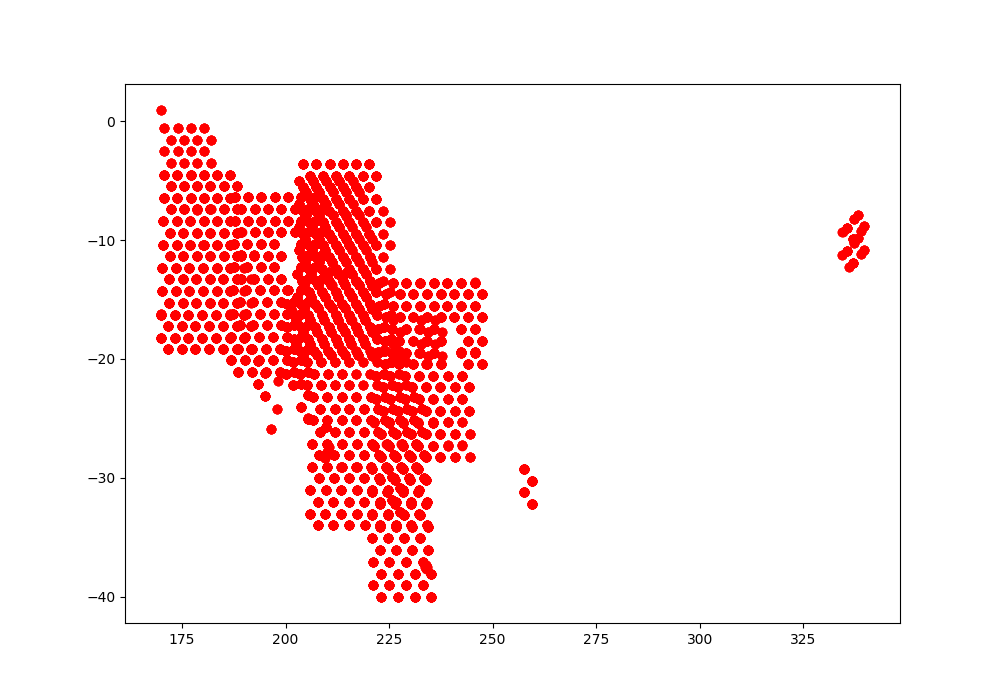

In [6]:
# recreate that plot for grouped pointings only (shouldn't be a lot of difference)
%matplotlib notebook
visit_id = pg["visit_id"]
ra       = pg["ra"]
dec      = pg["dec"]
plot_pointings(visit_id, ra, dec)

In [5]:
# We define "Bad Groups" as groups where the maximum separation between image centers is greater than 25 arcsec

Bad_Group_Index = []
Arcsec_Tol = 25 # Tolerance defining a bad group in arcseconds
for i in range(len(pg.groups)):
    RAResidual = pg[i]["ra"].data-np.mean(pg[i]["ra"].data)
    RAResidual*=3600
    DECResidual = pg[i]["dec"].data-np.mean(pg[i]["dec"].data)
    if (np.max(abs(RAResidual))>Arcsec_Tol or np.max(abs(DECResidual))>Arcsec_Tol):
        Bad_Group_Index.append(i)
    DECResidual*=3600
    #plt.plot(RAResidual,'r')
    #plt.plot(DECResidual,'b')
    
print("There are {bad_group_num} bad groups in the data.".format(bad_group_num=len(Bad_Group_Index)))
print("The indicies for the bad groups are:\n"+str(Bad_Group_Index))


There are 31 bad groups in the data.
The indicies for the bad groups are:
[172, 173, 174, 184, 492, 510, 524, 525, 526, 527, 528, 529, 531, 533, 535, 538, 539, 540, 541, 542, 543, 544, 546, 548, 549, 597, 690, 691, 753, 761, 778]


<IPython.core.display.Javascript object>


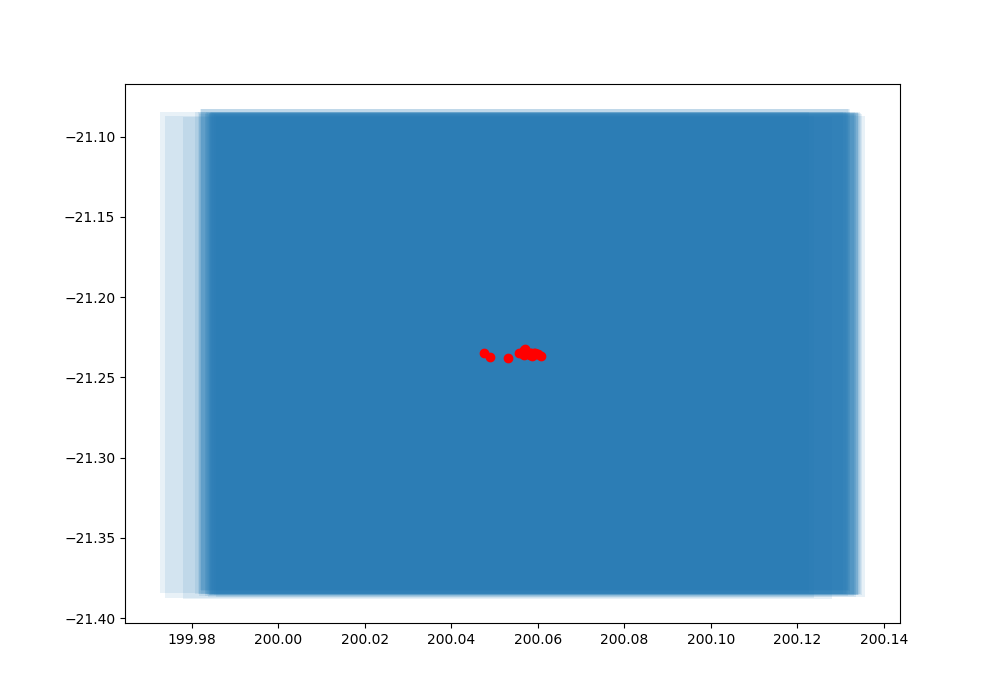

<IPython.core.display.Javascript object>


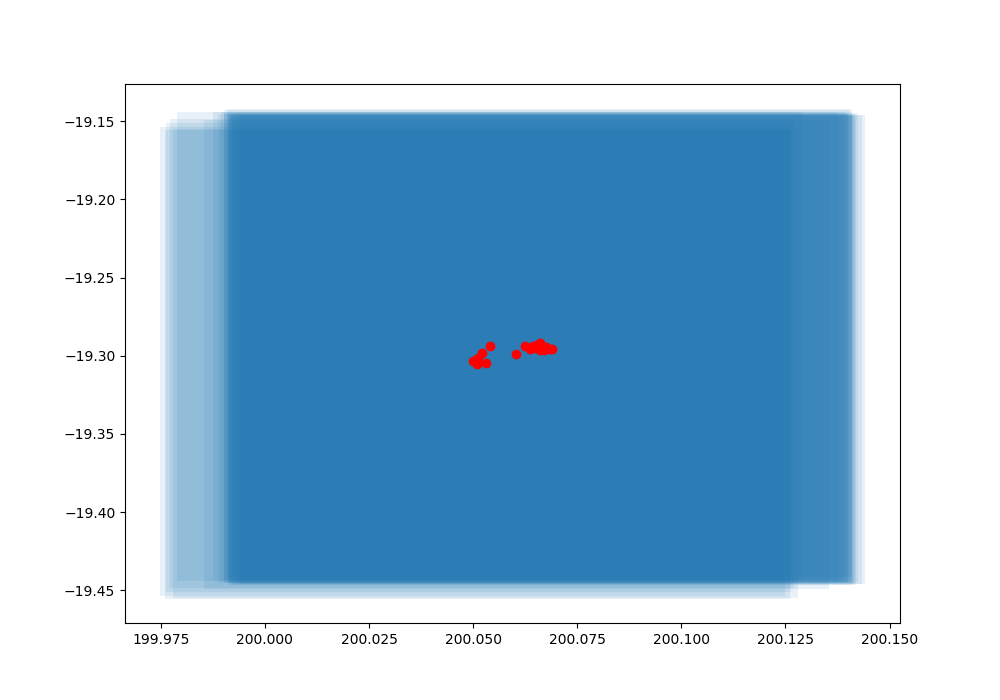

<IPython.core.display.Javascript object>


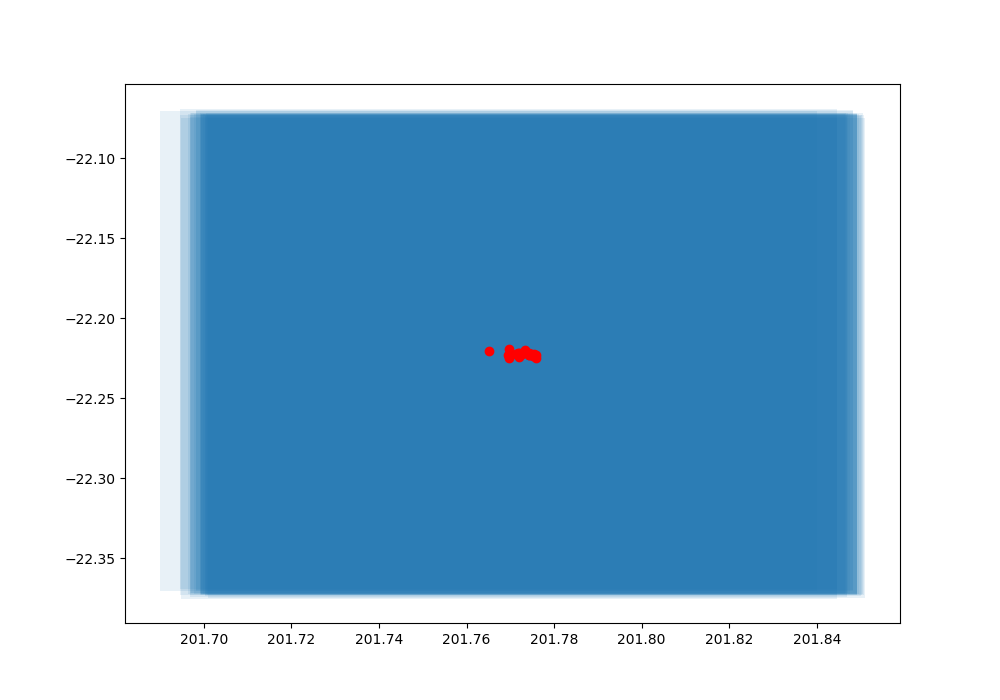

<IPython.core.display.Javascript object>


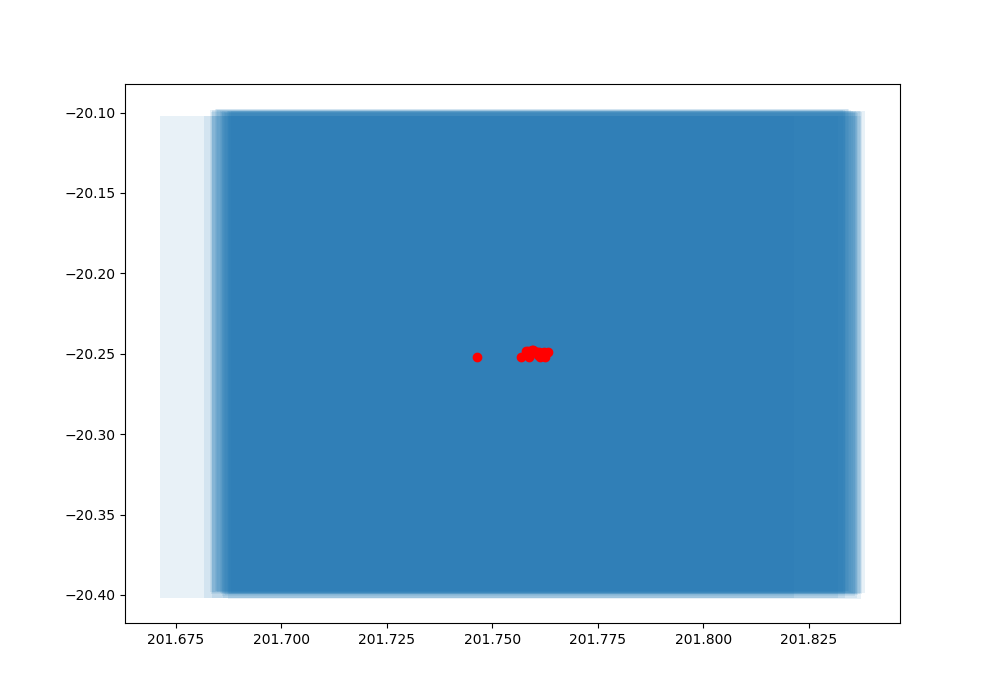

<IPython.core.display.Javascript object>


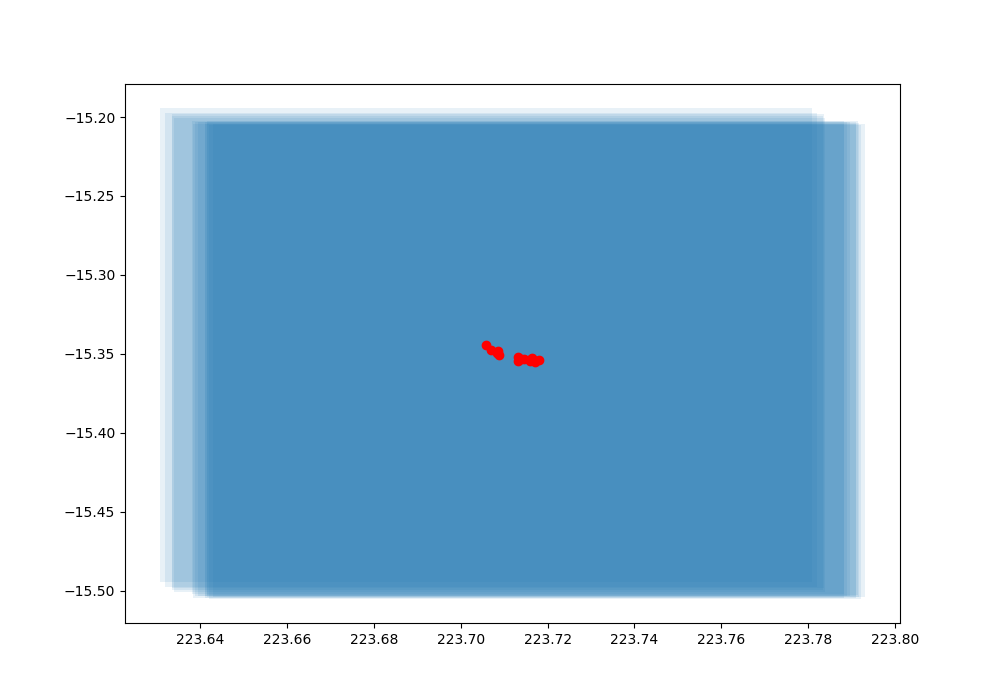

<IPython.core.display.Javascript object>


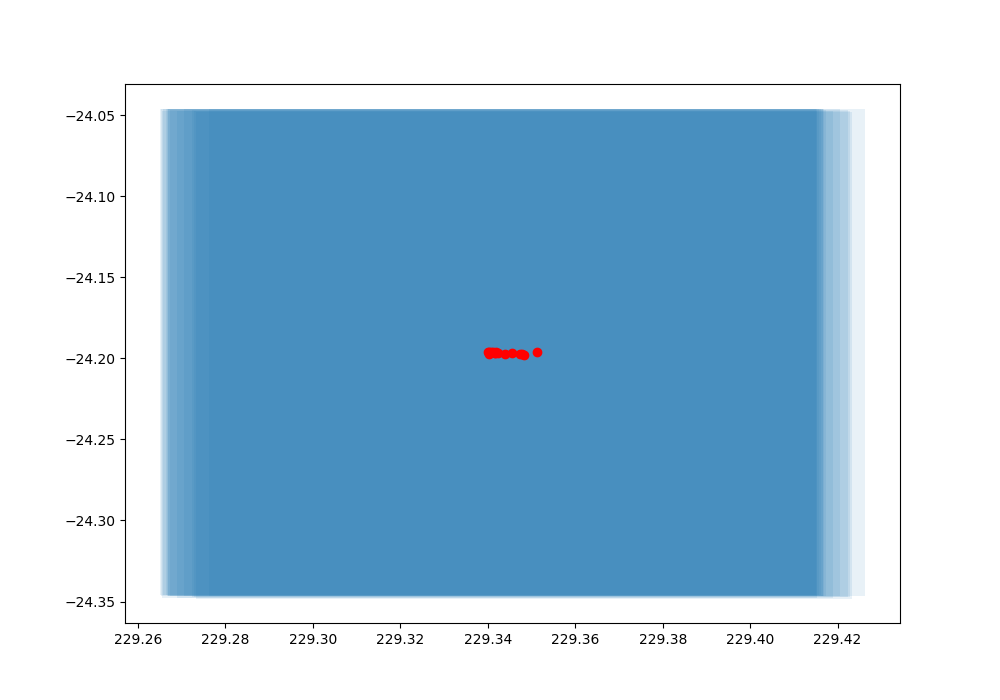

<IPython.core.display.Javascript object>


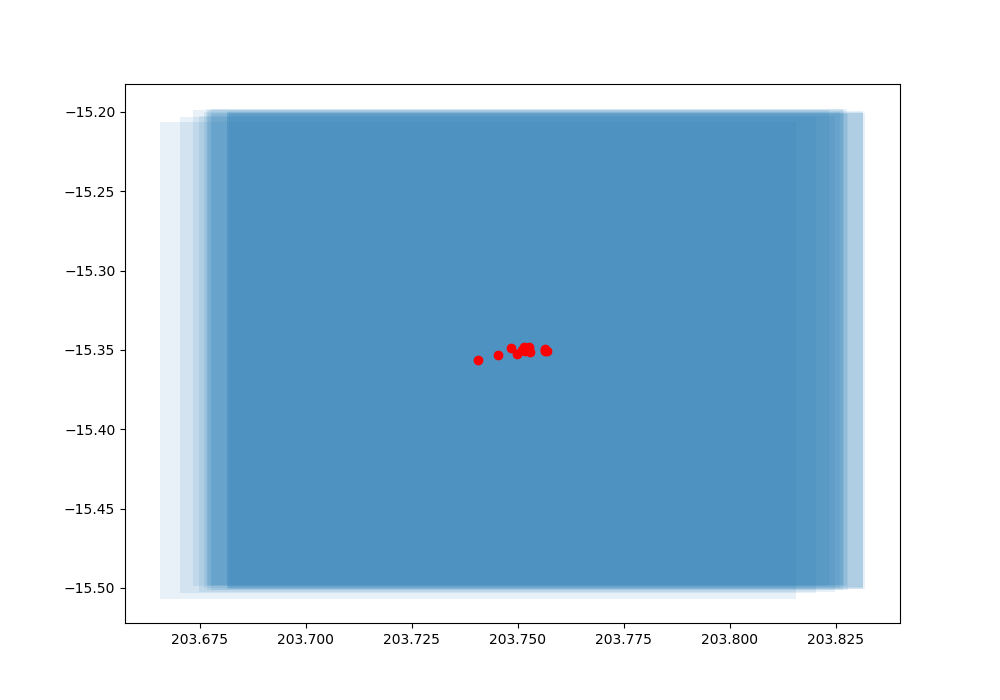

<IPython.core.display.Javascript object>


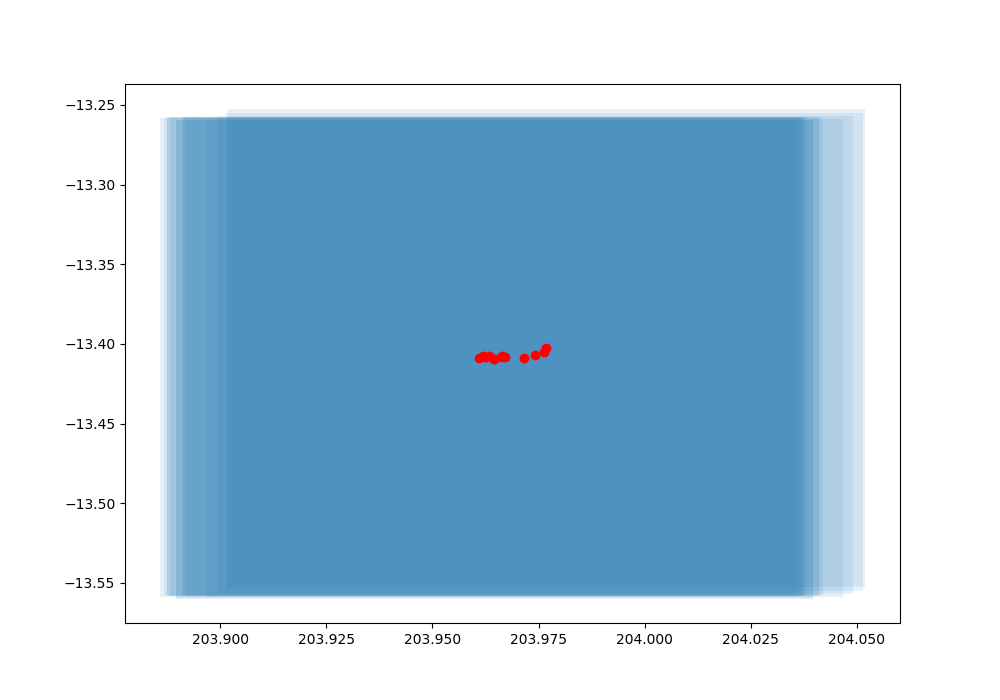

<IPython.core.display.Javascript object>


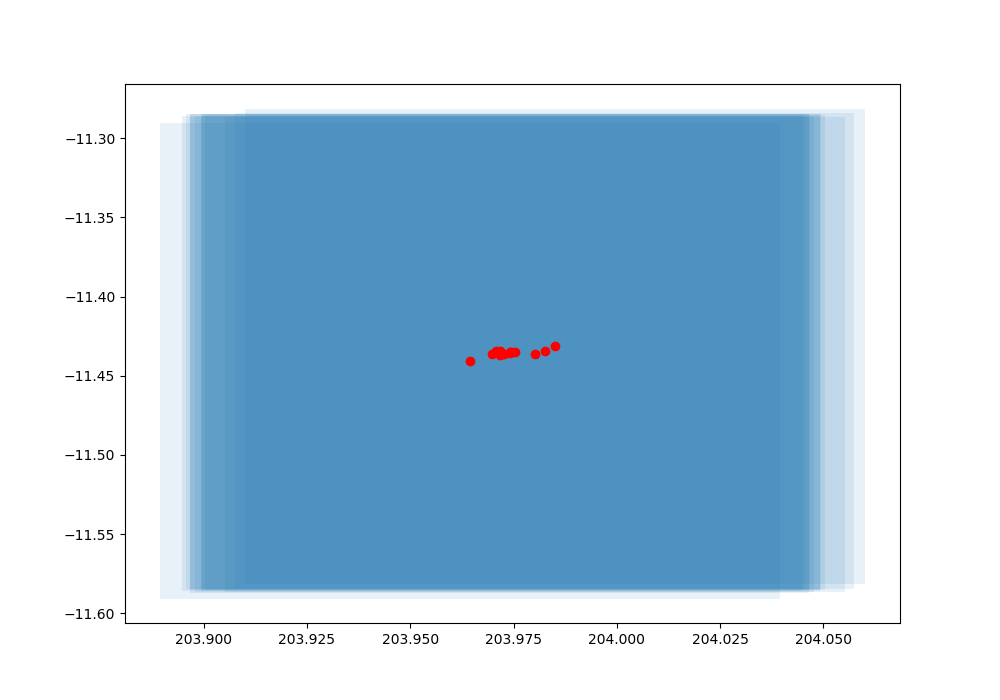

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/home/hayden/.anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# This cell plots the bad pointings in order to visualize the spread of pointings in the bad pointing groups
%matplotlib notebook
for index in Bad_Group_Index:
    plot_pointings(pg[index]["visit_id"],pg[index]["ra"],pg[index]["dec"])

<IPython.core.display.Javascript object>


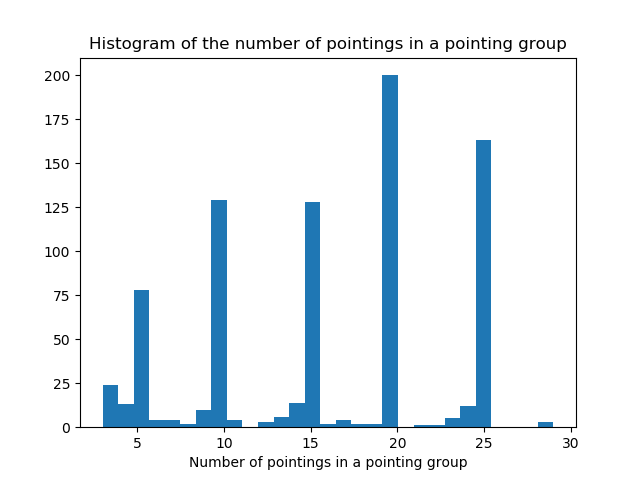

Text(0.5,0,'Number of pointings in a pointing group')

In [7]:
%matplotlib notebook
num_visits = []
[num_visits.append(len(x)) for x in pg]
plt.figure()
plt.hist(num_visits,bins=29)
plt.title('Histogram of the number of pointings in a pointing group')
plt.xlabel('Number of pointings in a pointing group')

In [9]:
# This cell generates the bash linking script needed prior to ingesting the data with the LSST stack

index = 10
with open("link_files_"+pg[index]["ingest_folder"][0]+".sh", "w") as f:

    dir_name = pg[index]["ingest_folder"][0]
    f.write('\n# Link files for field: '+dir_name+'\n')
    f.write('mkdir '+dir_name+'\n')
    f.write('mkdir '+dir_name+'/ingest/\n')
    f.write('mkdir '+dir_name+'/ingest/instcal\n')
    f.write('mkdir '+dir_name+'/ingest/dqmask\n')
    f.write('mkdir '+dir_name+'/ingest/wtmap\n')
    for i in range(len(pg[index])):
        if pg[index][i]["survey_night"] is not 3:
            link_files = ("ln -s /astro/store/pogo4/jbkalmbach/NEO/night_{nightnum}/night_{nightnum}/{filename} {destination}\n")
        else:
            link_files = ("ln -s /astro/store/pogo4/jbkalmbach/NEO/night_{nightnum}/night_{nightnum}/night_{night_num}/{filename} {destination}\n")


        dqmask = pg[index]['filename'][i].decode('UTF-8')[0:20]+'d'+pg[index]['filename'][i].decode('UTF-8')[21:]
        wtmap = pg[index]['filename'][i].decode('UTF-8')[0:20]+'w'+pg[index]['filename'][i].decode('UTF-8')[21:]
        
        destination = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/'+dir_name+'/ingest/instcal/\n'
        f.write(link_files.format(nightnum=pg[index]["survey_night"][i],filename=pg[index]["filename"][i].decode('UTF-8'),destination=destination))

        destination = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/'+dir_name+'/ingest/dqmask/\n'
        f.write(link_files.format(nightnum=pg[index]["survey_night"][i],filename=dqmask,destination=destination))
        
        destination = '/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/'+dir_name+'/ingest/wtmap/\n'
        f.write(link_files.format(nightnum=pg[index]["survey_night"][i],filename=wtmap,destination=destination))

In [9]:
# Pairs are created from grouped pointings by iterating through all the pointings in a group and calculating the
# time difference dt between two exposures. The pair that has the largest dt will be image differenced. 
# For testing purposes we start from the pointing ra, dec = (207.354958, -7.519750). 
foi = pg[0]
pairs = []

for science in foi:
    sci_obsdate = science["date_obs"]
    sci_id = science["visit_id"]
    sci_ra = science["ra"]
    sci_dec = science["dec"]
    sci_filename = science["filename"]
    sci_date = time.Time(sci_obsdate.decode("utf-8"))
    
    maxdt = 0 
    for template in foi: 
        tmplt_obsdate = template["date_obs"]
        tmplt_id = template["visit_id"]
        tmplt_ra = template["ra"]
        tmplt_dec = template["dec"]
        tmplt_filename = template["filename"]
        tmplt_date = time.Time(tmplt_obsdate.decode("utf-8"))
        
        # dt is a astropy.time.TimeDelta object and can not be compared to non TimeDelta objects
        # it recognizes positive and negative time delta so we check for its absolute value
        dt = sci_date - tmplt_date
        if abs(dt) > time.TimeDelta(maxdt, format="sec"):
            maxdt = dt
            if sci_id != tmplt_id:
                pair = (science[1], template[1], abs(dt))   
        try:
            pairs.append(pair)
        except:
            print("Pair not found. Check the group.")
    maxdt = time.TimeDelta(0, format="sec")

Pair not found. Check the group.


In [18]:
# check if all pairs make sense, third columns is the dt in hours
for pair in pairs:
    print(pair[0]["visit_id"], pair[1]["visit_id"], pair[2].sec/60./60.)

In [20]:
# Create the image differencing scripts in folder jobs

rerunpath = "/astro/store/epyc/users/smotherh/DECAM_Data_Reduction/fields/r207.354958d-7.519750/Processed_Data/rerun/singleFrameDriver_rerun"

ncpu = 20
outpath = "imdiff_r207.354958d-7.519750"
cfgfile = "config.py"
cmd = ("imageDifference.py {rerunpath} -j {ncpu} --output {outpath} -C {cfgfile} --longlog "+
       "--timeout 18000 --id visit={visitid} --templateId visit={templateid}\n")

with open("jobs/jobs_specialty.sh", "w") as f:
    for pair in pairs:
        f.write(cmd.format(rerunpath=rerunpath, ncpu=ncpu, outpath=outpath, cfgfile=cfgfile, 
                           visitid=int(pair[0]["visit_id"]), templateid=int(pair[1]["visit_id"])))